In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/guwei/envs/uc1/local/lib/python2.7/site-packages')

from keras.layers import Input, merge
from keras.models import Model,Sequential
from layers import VGGNormalize,ReflectionPadding2D,Denormalize,conv_bn_relu,res_conv,dconv_bn_nolinear
from loss import dummy_loss,StyleReconstructionRegularizer,FeatureReconstructionRegularizer,TVRegularizer
from keras.optimizers import Adam, SGD,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from scipy.misc import imsave,imread,imresize
import time
import numpy as np
import argparse

from keras.callbacks import TensorBoard
from scipy import ndimage

import nets
print('load done')

Using TensorFlow backend.


load done


/home/fluke/envs/uc/local/lib/python2.7/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/fluke/envs/uc/local/lib/python2.7/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Getting style features from VGG network.
(['./data/content/000000539883.jpg', './data/content/000000311518.jpg', './data/content/000000037988.jpg', './data/content/000000561889.jpg', './data/content/000000279541.jpg'], 5000)
(9455456.0, 36.0836968421936)
('epoc: ', 200)
((2, 256, 256, 3), (2, 256, 256, 3))


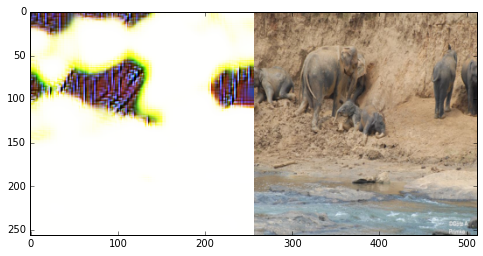

(4125505.5, 81.40654993057251)
('epoc: ', 700)
((2, 256, 256, 3), (2, 256, 256, 3))


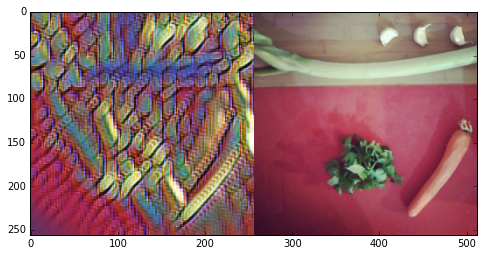

(3230401.0, 80.82986807823181)
('epoc: ', 1200)
((2, 256, 256, 3), (2, 256, 256, 3))


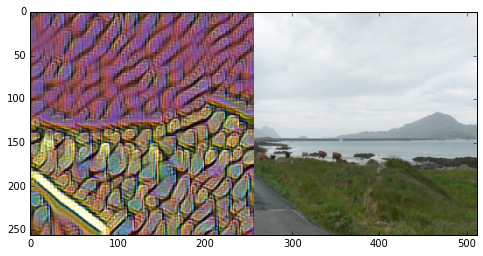

(1982733.9, 80.94833707809448)
('epoc: ', 1700)
((2, 256, 256, 3), (2, 256, 256, 3))


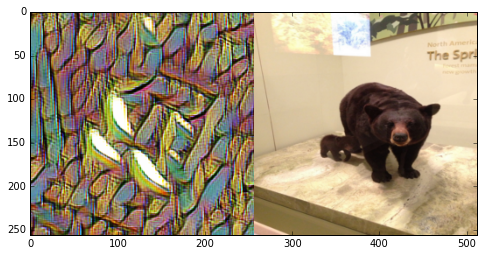

(2011486.4, 80.3711109161377)
('epoc: ', 2200)
((2, 256, 256, 3), (2, 256, 256, 3))


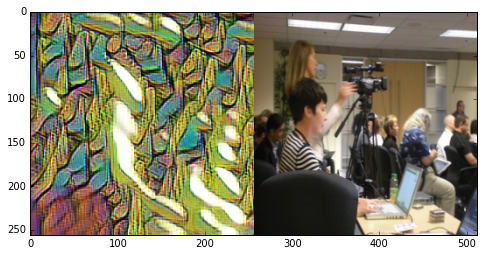

In [3]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def my_datagen(file_dir,batch_size,img_size):
    fl = glob.glob(file_dir + '/*')
    file_cnt = len(fl)
    print(fl[:5],file_cnt)
    idx = 0
    while True:
        x = []
        if idx + batch_size <= file_cnt:
            s,e = idx,idx + batch_size
            idx = idx + batch_size
        else:
            s,e = 0,batch_size
            idx = batch_size
        for f in fl[s:e]:
            img = imread(f,mode='RGB')
            img = imresize(img,img_size)
            x.append(img)
        yield np.array(x)

class FastNeuralStyle(object):
    def __init__(self, style_weight, content_weigth, tv_weight, style_p, img_size):
        self.style_w = style_weight
        self.content_w = content_weigth
        self.tv_w = tv_weight
        self.style_p = style_p
        self.img_size = img_size
        self.img_w, self.img_h = self.img_size

        

    def train(self, train_dir, nb_epoch, batch):
        # build net
        self.net = nets.image_transform_net(self.img_w, self.img_h, self.tv_w)
        self.model = nets.loss_net(self.net.output, self.net.input, self.img_w, self.img_h, self.style_p, self.content_w,
                                   self.style_w)
        
        learning_rate = 1e-3  # 1e-3
        optimizer = Adam(lr=learning_rate)  # Adam(lr=learning_rate,beta_1=0.99)

        self.model.compile(optimizer, dummy_loss)  # Dummy loss since we are learning from regularizes
        dummy_y = np.zeros((batch, self.img_w, self.img_h, 3))  # Dummy output, not used since we use regularizers to train
        datagen = my_datagen(train_dir,batch,(self.img_w,self.img_h))

        # start train
        i = 0
        t1 = time.time()
        for x in datagen:
            if i > nb_epoch:
                break

            i += 1
            hist = self.model.train_on_batch(x, dummy_y)

            # check
            if i % 500 == 200:
                print(hist, (time.time() - t1))
                t1 = time.time()
                print("epoc: ", i)
                val_x = self.net.predict(x).astype(np.uint8)
                print(val_x.shape,x.shape)
                comb_img = np.concatenate((val_x[0],x[0]),axis=1)
                plt.figure(figsize=(12,4))
                plt.imshow(comb_img)
                plt.show()
                self.model.save_weights('la_muse_nn_weights.h5')

nn = FastNeuralStyle(style_weight=4.0,content_weigth=1.0,tv_weight=1e-6,style_p='./data/style/la_muse.jpg',img_size=(256,256))

# val2017 has 5k images
# style has 3 style images
nn.train('./data/content',2300,2)